## Dependencias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
from functools import reduce
pd.set_option('display.max_columns',5000)

## Funciones auxiliares

In [2]:
def freq(df,var):
    if type(var)!= list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame().rename(columns={v:'FA'})
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux[['FA','FR']].apply(np.cumsum)
    
        print(f'Tabla de frecuencias para la variable {v}\n\n\n')
        print(aux,"\n"*3)

## Lectura de datos y preprocesamiento

In [3]:
ruta = '/home/jose/Documentos/bd/chicago/'

In [4]:
l_arch = sorted([os.path.join(ruta,arch) for arch in os.listdir(ruta) if arch[-3:]=='csv'])

In [5]:
js = json.load(open(os.path.join(ruta,'column_remapping.json'),'r'))

In [6]:
def leer_datos(arch,js):
    print(arch)
    df = pd.read_csv(arch)
    df.drop(['pickup_census_tract',
             'dropoff_census_tract',
             'pickup_community_area',
             'dropoff_community_area'],axis=1,inplace=True)
    df = df.loc[~df['taxi_id'].isnull()].reset_index(drop=True)
    for k in js.keys():
        if k not in ['pickup_census_tract','dropoff_census_tract']:
            df[k] = df[k].fillna(999999).astype(int).astype(str).map(js[k])

    df['company'].fillna('Independent',inplace=True)

    df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
    df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

    return df

In [7]:
df = pd.concat(map(lambda arch:leer_datos(arch,js),l_arch),ignore_index=True)

/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_01.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_02.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_03.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_04.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_05.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_06.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_07.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_08.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_09.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_10.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_11.csv
/home/jose/Documentos/bd/chicago/chicago_taxi_trips_2016_12.csv


In [8]:
df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,58dd35601f224bc255e2d882fee540d5cabf30cabc55cf...,2016-01-13 06:15:00,2016-01-13 06:15:00,180.0,0.40,4.50,0.00,0.0,0.0,4.50,Cash,Taxi Affiliation Services,41.901206994,-87.676355989,41.901206994,-87.676355989
1,3ed810b836bba3322619f5131e823fe16dbe3cb4781a2a...,2016-01-22 09:30:00,2016-01-22 09:45:00,240.0,0.70,4.45,4.45,0.0,0.0,8.90,Credit Card,Independent,NaN,NaN,NaN,NaN
2,451d7c5b2e7cb5e9d95308fe88262b5c32559a595b5aac...,2016-01-31 21:30:00,2016-01-31 21:30:00,0.0,0.00,42.75,5.00,0.0,0.0,47.75,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN
3,e1eecbf25b46d395e07e282877c4f1019018307700cc13...,2016-01-23 17:30:00,2016-01-23 17:30:00,480.0,1.10,7.00,0.00,0.0,0.0,7.00,Cash,Independent,41.944226601,-87.655998182,41.944226601,-87.655998182
4,68ae6c89f7967f770fb6c05a367f4061c9ce97206f7b88...,2016-01-14 05:45:00,2016-01-14 06:00:00,480.0,2.71,10.25,0.00,0.0,0.0,10.25,Cash,Independent,41.878865584,-87.625192142,NaN,NaN


### Muestreo

In [9]:
s = df[['taxi_id']].drop_duplicates().sample(n=500).reset_index(drop=True)
s = s.merge(df,on='taxi_id',how='inner')
s.head()
s = s.loc[s['payment_type'].isin(['Cash','Credit Card'])].reset_index(drop=True)

s['company'] = np.where(s['company'].isin(['Independent',
'Taxi Affiliation Services',
'Choice Taxi Association',
'Dispatch Taxi Affiliation',
'Blue Ribbon Taxi Association Inc.']),s['company'],'other')

freq(s,['payment_type','company'])

s['week'] = s['trip_start_timestamp'].map(lambda x:x.strftime('%W')).astype(int)

Tabla de frecuencias para la variable payment_type



                 FA        FR      FAA       FRA
Cash         714022  0.535863   714022  0.535863
Credit Card  618450  0.464137  1332472  1.000000 



Tabla de frecuencias para la variable company



                                       FA        FR      FAA       FRA
Independent                        456943  0.342929   456943  0.342929
Taxi Affiliation Services          404663  0.303693   861606  0.646622
other                              161469  0.121180  1023075  0.767802
Dispatch Taxi Affiliation          114221  0.085721  1137296  0.853523
Blue Ribbon Taxi Association Inc.  105558  0.079220  1242854  0.932743
Choice Taxi Association             89618  0.067257  1332472  1.000000 





## Ventanas de tiempo

In [10]:
anclai, anclaf = s['week'].min(),s['week'].max()
anclai, anclaf

(0, 52)

In [11]:
vobs = 6
vpred = 2

In [12]:
anclai = vobs-1
anclaf-=vpred
anclai,anclaf

(5, 50)

In [13]:
for ancla in range(anclai,anclaf+1):
    print(f'voy a usar las semanas{list(range(ancla-vobs+1,ancla+1))} para predecir en las semanas {list(range(ancla+1,ancla+vpred+1))}')

voy a usar las semanas[0, 1, 2, 3, 4, 5] para predecir en las semanas [6, 7]
voy a usar las semanas[1, 2, 3, 4, 5, 6] para predecir en las semanas [7, 8]
voy a usar las semanas[2, 3, 4, 5, 6, 7] para predecir en las semanas [8, 9]
voy a usar las semanas[3, 4, 5, 6, 7, 8] para predecir en las semanas [9, 10]
voy a usar las semanas[4, 5, 6, 7, 8, 9] para predecir en las semanas [10, 11]
voy a usar las semanas[5, 6, 7, 8, 9, 10] para predecir en las semanas [11, 12]
voy a usar las semanas[6, 7, 8, 9, 10, 11] para predecir en las semanas [12, 13]
voy a usar las semanas[7, 8, 9, 10, 11, 12] para predecir en las semanas [13, 14]
voy a usar las semanas[8, 9, 10, 11, 12, 13] para predecir en las semanas [14, 15]
voy a usar las semanas[9, 10, 11, 12, 13, 14] para predecir en las semanas [15, 16]
voy a usar las semanas[10, 11, 12, 13, 14, 15] para predecir en las semanas [16, 17]
voy a usar las semanas[11, 12, 13, 14, 15, 16] para predecir en las semanas [17, 18]
voy a usar las semanas[12, 13, 1

## Ingeniería de datos

### Definición de tipos de variables y UM

In [14]:
um = ['taxi_id','ancla']
varc = ['trip_seconds','trip_miles', 'fare', 'tips', 'tolls', 
        'extras', 'trip_total', 'pickup_latitude', 'pickup_longitude',
        'dropoff_latitude', 'dropoff_longitude']
var_seg = ['payment_type', 'company']

In [15]:
for v in varc:
    s[v] = pd.to_numeric(s[v],errors='coerce')

### Matriz de predictoras $\mathcal{X}$

In [16]:
def predictoras(d,ancla,varc,sub,segm,total=False):
    print(ancla)
    varg = ['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']
    varc = [v for v in varc if v not in varg]
    
    aux1 = d.loc[(d['week']>=ancla-sub+1)&(d['week']<=ancla)].copy().reset_index(drop=True)
    aux1 = aux1.pivot_table(index=['taxi_id'],columns=segm,values=varc,aggfunc=['min','max','mean','median','std','count'])
    aux1.columns = [f'x_{x}_{y}_{segm}_{z}_{sub}' for x,y,z in aux1.columns]

    aux2 = d.loc[(d['week']>=ancla-sub+1)&(d['week']<=ancla)].copy().reset_index(drop=True)
    aux2 = aux2.pivot_table(index=['taxi_id'],columns=segm,values=varg,aggfunc=['mean'])
    aux2.columns = [f'x_{x}_{y}_{segm}_{z}_{sub}' for x,y,z in aux2.columns]
    
    if total:
        aux = d.loc[(d['week']>=ancla-sub+1)&(d['week']<=ancla)].copy().reset_index(drop=True)
        aux = pd.merge(aux[varc+['taxi_id']].groupby('taxi_id').agg(['min','max','mean','median','std']),
                       aux[varg+['taxi_id']].groupby('taxi_id').agg(['mean']),
                       left_index=True,
                       right_index=True,
                       how='outer')
        aux.columns = [f'x_{y}_{x}_{sub}_tot' for x,y in aux.columns]
        tot = aux.copy()
        aux = aux1.merge(aux2,left_index=True,right_index=True,how='outer')
        aux = aux.merge(tot,left_index=True,right_index=True,how='outer')
        aux.reset_index(inplace=True)
        aux.insert(1,'ancla',ancla)
        return aux
    else:
        aux = aux1.merge(aux2,left_index=True,right_index=True,how='outer')
        aux.reset_index(inplace=True)
        aux.insert(1,'ancla',ancla)
        return aux
    

In [17]:
step = 2
X = pd.concat(map(lambda ancla:reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),
                            map(lambda k:reduce(lambda x,y:pd.merge(x,y,on=um,how='outer'),
       map(lambda z:predictoras(s,ancla,varc,k,*z),zip(var_seg,[True,False]))),range(step,vobs+step,step))),range(anclai,anclaf+1)),ignore_index=True)

5
5
5
5
5
5
6
6
6
6
6
6
7
7
7
7
7
7
8
8
8
8
8
8
9
9
9
9
9
9
10
10
10
10
10
10
11
11
11
11
11
11
12
12
12
12
12
12
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
15
16
16
16
16
16
16
17
17
17
17
17
17
18
18
18
18
18
18
19
19
19
19
19
19
20
20
20
20
20
20
21
21
21
21
21
21
22
22
22
22
22
22
23
23
23
23
23
23
24
24
24
24
24
24
25
25
25
25
25
25
26
26
26
26
26
26
27
27
27
27
27
27
28
28
28
28
28
28
29
29
29
29
29
29
30
30
30
30
30
30
31
31
31
31
31
31
32
32
32
32
32
32
33
33
33
33
33
33
34
34
34
34
34
34
35
35
35
35
35
35
36
36
36
36
36
36
37
37
37
37
37
37
38
38
38
38
38
38
39
39
39
39
39
39
40
40
40
40
40
40
41
41
41
41
41
41
42
42
42
42
42
42
43
43
43
43
43
43
44
44
44
44
44
44
45
45
45
45
45
45
46
46
46
46
46
46
47
47
47
47
47
47
48
48
48
48
48
48
49
49
49
49
49
49
50
50
50
50
50
50


In [18]:
X.head()

,taxi_id,ancla,x_min_extras_payment_type_Cash_2,x_min_extras_payment_type_Credit Card_2,x_min_fare_payment_type_Cash_2,x_min_fare_payment_type_Credit Card_2,x_min_tips_payment_type_Cash_2,x_min_tips_payment_type_Credit Card_2,x_min_tolls_payment_type_Cash_2,x_min_tolls_payment_type_Credit Card_2,x_min_trip_miles_payment_type_Cash_2,x_min_trip_miles_payment_type_Credit Card_2,x_min_trip_seconds_payment_type_Cash_2,x_min_trip_seconds_payment_type_Credit Card_2,x_min_trip_total_payment_type_Cash_2,x_min_trip_total_payment_type_Credit Card_2,x_max_extras_payment_type_Cash_2,x_max_extras_payment_type_Credit Card_2,x_max_fare_payment_type_Cash_2,x_max_fare_payment_type_Credit Card_2,x_max_tips_payment_type_Cash_2,x_max_tips_payment_type_Credit Card_2,x_max_tolls_payment_type_Cash_2,x_max_tolls_payment_type_Credit Card_2,x_max_trip_miles_payment_type_Cash_2,x_max_trip_miles_payment_type_Credit Card_2,x_max_trip_seconds_payment_type_Cash_2,x_max_trip_seconds_payment_type_Credit Card_2,x_max_trip_total_payment_type_Cash_2,x_max_trip_total_payment_type_Credit Card_2,x_mean_extras_payment_type_Cash_2,x_mean_extras_payment_type_Credit Card_2,x_mean_fare_payment_type_Cash_2,x_mean_fare_payment_type_Credit Card_2,x_mean_tips_payment_type_Cash_2,x_mean_tips_payment_type_Credit Card_2,x_mean_tolls_payment_type_Cash_2,x_mean_tolls_payment_type_Credit Card_2,x_mean_trip_miles_payment_type_Cash_2,x_mean_trip_miles_payment_type_Credit Card_2,x_mean_trip_seconds_payment_type_Cash_2,x_mean_trip_seconds_payment_type_Credit Card_2,x_mean_trip_total_payment_type_Cash_2,x_mean_trip_total_payment_type_Credit Card_2,x_median_extras_payment_type_Cash_2,x_median_extras_payment_type_Credit Card_2,x_median_fare_payment_type_Cash_2,x_median_fare_payment_type_Credit Card_2,x_median_tips_payment_type_Cash_2,x_median_tips_payment_type_Credit Card_2,x_median_tolls_payment_type_Cash_2,x_median_tolls_payment_type_Credit Card_2,x_median_trip_miles_payment_type_Cash_2,x_median_trip_miles_payment_type_Credit Card_2,x_median_trip_seconds_payment_type_Cash_2,x_median_trip_seconds_payment_type_Credit Card_2,x_median_trip_total_payment_type_Cash_2,x_median_trip_total_payment_type_Credit Card_2,x_std_extras_payment_type_Cash_2,x_std_extras_payment_type_Credit Card_2,x_std_fare_payment_type_Cash_2,x_std_fare_payment_type_Credit Card_2,x_std_tips_payment_type_Cash_2,x_std_tips_payment_type_Credit Card_2,x_std_tolls_payment_type_Cash_2,x_std_tolls_payment_type_Credit Card_2,x_std_trip_miles_payment_type_Cash_2,x_std_trip_miles_payment_type_Credit Card_2,x_std_trip_seconds_payment_type_Cash_2,x_std_trip_seconds_payment_type_Credit Card_2,x_std_trip_total_payment_type_Cash_2,x_std_trip_total_payment_type_Credit Card_2,x_count_extras_payment_type_Cash_2,x_count_extras_payment_type_Credit Card_2,x_count_fare_payment_type_Cash_2,x_count_fare_payment_type_Credit Card_2,x_count_tips_payment_type_Cash_2,x_count_tips_payment_type_Credit Card_2,x_count_tolls_payment_type_Cash_2,x_count_tolls_payment_type_Credit Card_2,x_count_trip_miles_payment_type_Cash_2,x_count_trip_miles_payment_type_Credit Card_2,x_count_trip_seconds_payment_type_Cash_2,x_count_trip_seconds_payment_type_Credit Card_2,x_count_trip_total_payment_type_Cash_2,x_count_trip_total_payment_type_Credit Card_2,x_mean_dropoff_latitude_payment_type_Cash_2,x_mean_dropoff_latitude_payment_type_Credit Card_2,x_mean_dropoff_longitude_payment_type_Cash_2,x_mean_dropoff_longitude_payment_type_Credit Card_2,x_mean_pickup_latitude_payment_type_Cash_2,x_mean_pickup_latitude_payment_type_Credit Card_2,x_mean_pickup_longitude_payment_type_Cash_2,x_mean_pickup_longitude_payment_type_Credit Card_2,x_min_trip_seconds_2_tot,x_max_trip_seconds_2_tot,x_mean_trip_seconds_2_tot,x_median_trip_seconds_2_tot,x_std_trip_seconds_2_tot,x_min_trip_miles_2_tot,x_max_trip_miles_2_tot,x_mean_trip_miles_2_tot,x_median_trip_miles_2_tot,x_std_trip_miles_2_tot,x_min_fare_2_tot,x_max_fare_2_tot,x_mean_fare_2_tot,x_median_fare_2_tot,x_std_fare_2_tot,x_min_tips

In [19]:
X.shape

(17259, 1223)

### Variable respuesta (objetivo) $\vec{y}$

In [20]:
def target(df,ancla):
    aux = df.loc[(df['week']>ancla)&(df['week']<=(ancla+vpred))][['taxi_id']].copy().drop_duplicates().reset_index(drop=True)
    aux.insert(1,'ancla',ancla)
    aux['churn'] = 0
    return aux

In [21]:
y = pd.concat(map(lambda ancla:target(s,ancla),range(anclai,anclaf+1)),ignore_index=True)

### TAD $S_n=\lbrace(x^{(i)},y^{(i)}),i=1,\ldots,n\rbrace$

In [22]:
tad = X.merge(y,on=um,how='left')

In [23]:
tad['churn'].fillna(1,inplace=True)

In [24]:
freq(tad,'churn')

Tabla de frecuencias para la variable churn



        FA        FR    FAA       FRA
0.0  14951  0.866273  14951  0.866273
1.0   2308  0.133727  17259  1.000000 





## Análisis Exploratorio

### Missing

In [25]:
varc = [v for v in tad.columns if v[:2]=='x_']
miss = 1-tad[varc].describe().T[['count']]/len(tad)


In [26]:
varc = miss.loc[miss['count']<=0.3].index.tolist()

### Unarias

In [27]:
from sklearn.feature_selection import VarianceThreshold

In [28]:
vt = VarianceThreshold()

In [29]:
vt.fit(tad[varc])

VarianceThreshold()

In [30]:
unarias = [v for v,b in zip(varc,vt.get_support()) if not b]

In [31]:
varc = [v for v in varc if v not in unarias]

In [32]:
len(varc)

351

### Imputación

In [33]:
from sklearn.impute import SimpleImputer
from scipy.stats import ks_2samp

In [34]:
im = SimpleImputer(strategy='median')

In [35]:
im.fit(tad[varc])

SimpleImputer(strategy='median')

In [36]:
X = tad[varc].copy()

In [37]:
X[varc] = pd.DataFrame(im.transform(tad[varc]),columns=varc)
X[um] = tad[um]

In [38]:
X.shape,X.dropna().shape

((17259, 353), (17259, 353))

In [39]:
ks = []
for v in varc:
    ks.append((v,ks_2samp(X[v],tad[v].dropna()).statistic))

In [40]:
ks = pd.DataFrame(ks,columns=['variable','ks'])

In [41]:
fuera = ks.loc[ks['ks']>0.1]['variable'].tolist()
len(fuera)

95

In [42]:
varc = [v for v in varc if v not in fuera]

In [43]:
len(varc)

256

### Extremos

In [44]:
for v,li,ls in X[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ext_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)

In [45]:
X['ext'] = X.filter(like='ext_').max(axis=1)

In [46]:
freq(X,'ext')

Tabla de frecuencias para la variable ext



      FA        FR    FAA       FRA
0  11115  0.644012  11115  0.644012
1   6144  0.355988  17259  1.000000 





In [47]:
X.drop([v for v in X.columns if v[:3]=='ext'],axis=1,inplace=True)

#### Extremo multivariado

In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [49]:
pi = make_pipeline(MinMaxScaler(),KMeans(n_clusters=20,n_jobs=-1))

In [50]:
X.columns

Index(['x_min_extras_payment_type_Cash_2',
       'x_min_extras_payment_type_Credit Card_2',
       'x_min_fare_payment_type_Cash_2',
       'x_min_fare_payment_type_Credit Card_2',
       'x_min_tips_payment_type_Credit Card_2',
       'x_min_trip_miles_payment_type_Cash_2',
       'x_min_trip_miles_payment_type_Credit Card_2',
       'x_min_trip_seconds_payment_type_Cash_2',
       'x_min_trip_seconds_payment_type_Credit Card_2',
       'x_min_trip_total_payment_type_Cash_2',
       ...
       'x_max_trip_total_6_tot', 'x_mean_trip_total_6_tot',
       'x_median_trip_total_6_tot', 'x_std_trip_total_6_tot',
       'x_mean_pickup_latitude_6_tot', 'x_mean_pickup_longitude_6_tot',
       'x_mean_dropoff_latitude_6_tot', 'x_mean_dropoff_longitude_6_tot',
       'taxi_id', 'ancla'],
      dtype='object', length=353)

In [51]:
pi.fit(X[varc])

/home/jose/entornos/churn/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kmeans', KMeans(n_clusters=20, n_jobs=-1))])

In [52]:
X['cl'] = pi.predict(X[varc])

In [53]:
aux = X['cl'].value_counts(True).to_frame().reset_index()

In [54]:
aux = aux.sort_values(by='cl',ascending=True).reset_index(drop=True)

In [55]:
aux['cl'] = aux['cl'].cumsum()

In [56]:
X = X.loc[~X['cl'].isin(aux.loc[aux['cl']<0.1]['index'].to_list())].reset_index(drop=True)

In [57]:
X.drop('cl',axis=1,inplace=True)

### Reducción de dimensiones

#### Clustering de variables

In [58]:
from varclushi import VarClusHi

In [59]:
vc = VarClusHi(df=X,feat_list=varc)

In [60]:
vc.varclus([])

In [61]:
rs = vc.rsquare

In [62]:
rs = rs.sort_values(by=['Cluster','RS_Ratio'],ascending=[1,1]).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount()+1

In [63]:
varc = rs.loc[rs['id']==1]['Variable'].tolist()

array([[<AxesSubplot:title={'center':'x_mean_trip_seconds_payment_type_Credit Card_2'}>,
        <AxesSubplot:title={'center':'x_mean_fare_payment_type_Credit Card_4'}>,
        <AxesSubplot:title={'center':'x_mean_tolls_4_tot'}>,
        <AxesSubplot:title={'center':'x_mean_tips_payment_type_Credit Card_4'}>,
        <AxesSubplot:title={'center':'x_count_trip_seconds_payment_type_Credit Card_6'}>,
        <AxesSubplot:title={'center':'x_std_extras_6_tot'}>,
        <AxesSubplot:title={'center':'x_mean_trip_miles_payment_type_Credit Card_2'}>],
       [<AxesSubplot:title={'center':'x_std_tips_payment_type_Cash_2'}>,
        <AxesSubplot:title={'center':'x_mean_fare_payment_type_Credit Card_6'}>,
        <AxesSubplot:title={'center':'x_median_extras_payment_type_Credit Card_4'}>,
        <AxesSubplot:title={'center':'x_std_tips_payment_type_Credit Card_6'}>,
        <AxesSubplot:title={'center':'x_std_fare_payment_type_Credit Card_4'}>,
        <AxesSubplot:title={'center':'x_std_trip_m

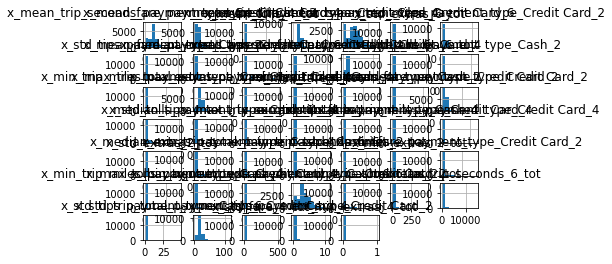

In [64]:
X[varc].hist()

#### Componentes principales $\mathcal{X}_d\to\mathcal{Z}_p, p\leq d$

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [66]:
pi = make_pipeline(StandardScaler(),PCA(n_components=37),MinMaxScaler())

In [67]:
pi.fit(X[varc])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=37)),
                ('minmaxscaler', MinMaxScaler())])

In [68]:
pi[-2].explained_variance_ratio_.cumsum()

array([0.12779298, 0.23759725, 0.29350438, 0.34023631, 0.38430105,
       0.42312471, 0.45884668, 0.49419482, 0.52681185, 0.55822671,
       0.58731138, 0.61565739, 0.6407669 , 0.66442058, 0.68765384,
       0.7099416 , 0.73196395, 0.75151758, 0.77013399, 0.7883777 ,
       0.80545688, 0.82191379, 0.83652389, 0.84982368, 0.86287375,
       0.87563853, 0.8877285 , 0.8992953 , 0.9105845 , 0.92031093,
       0.92988655, 0.93904164, 0.94755807, 0.95536357, 0.96307106,
       0.97024606, 0.97644579])

In [69]:
Z = pd.DataFrame(pi.transform(X[varc]),columns=[f'Z{i}' for i in range(1,37+1)])

In [70]:
Z[um] = X[um]

In [71]:
X[varc].corr().round(2)

,x_mean_trip_seconds_payment_type_Credit Card_2,x_mean_fare_payment_type_Credit Card_4,x_mean_tolls_4_tot,x_mean_tips_payment_type_Credit Card_4,x_count_trip_seconds_payment_type_Credit Card_6,x_std_extras_6_tot,x_mean_trip_miles_payment_type_Credit Card_2,x_std_tips_payment_type_Cash_2,x_mean_fare_payment_type_Credit Card_6,x_median_extras_payment_type_Credit Card_4,x_std_tips_payment_type_Credit Card_6,x_std_fare_payment_type_Credit Card_4,x_std_trip_miles_6_tot,x_std_tolls_payment_type_Cash_2,x_min_trip_miles_payment_type_Cash_6,x_max_trip_total_payment_type_Credit Card_4,x_max_extras_payment_type_Credit Card_4,x_max_fare_4_tot,x_min_trip_miles_payment_type_Cash_2,x_min_trip_seconds_payment_type_Credit Card_2,x_mean_fare_payment_type_Credit Card_2,x_median_tips_4_tot,x_std_tolls_payment_type_Cash_6,x_max_trip_seconds_4_tot,x_min_tips_4_tot,x_min_trip_total_payment_type_Cash_4,x_min_fare_payment_type_Credit Card_4,x_min_trip_miles_payment_type_Credit Card_4,x_std_extras_2_tot,x_median_extras_payment_type_Cash_4,x_min_trip_total_payment_type_Cash_6,x_min_trip_seconds_6_tot,x_std_trip_miles_2_tot,x_min_extras_2_tot,x_min_fare_payment_type_Credit Card_2,x_min_trip_miles_payment_type_Cash_4,x_max_tolls_payment_type_Credit Card_4,x_min_trip_seconds_payment_type_Cash_6,x_count_extras_payment_type_Credit Card_2,x_min_trip_total_6_tot,x_max_tips_2_tot,x_mean_trip_seconds_6_tot,x_std_tips_payment_type_Cash_6,x_std_trip_total_payment_type_Credit Card_4,x_std_fare_4_tot,x_min_tips_payment_type_Credit Card_2,x_min_extras_4_tot
x_mean_trip_seconds_payment_type_Credit Card_2,1.00,-0.06,0.13,0.55,0.21,0.13,0.72,0.03,-0.07,0.47,0.26,0.07,0.22,0.07,0.01,0.30,0.51,0.06,0.04,0.38,-0.04,-0.21,0.06,0.30,-0.02,-0.14,-0.21,0.17,0.10,0.25,-0.15,0.01,0.38,0.03,-0.32,0.03,0.11,-0.02,0.21,-0.18,0.24,0.75,0.04,0.26,0.03,0.02,0.00
x_mean_fare_payment_type_Credit Card_4,-0.06,1.00,0.03,0.03,-0.39,0.01,0.06,0.01,0.79,0.21,0.09,0.50,-0.01,0.01,-0.00,0.13,-0.10,0.04,-0.01,-0.08,0.74,0.26,-0.01,-0.16,0.12,0.06,0.75,-0.05,0.01,0.05,0.07,0.01,0.04,0.01,0.52,-0.00,-0.01,-0.00,-0.34,0.51,-0.06,-0.18,0.01,0.45,0.30,-0.02,-0.00
x_mean_tolls_4_tot,0.13,0.03,1.00,0.12,0.03,0.01,0.17,-0.01,0.01,0.10,0.06,0.06,0.05,0.47,-0.00,0.11,0.14,0.00,0.03,0.06,0.04,0.06,0.34,0.01,-0.01,-0.02,-0.03,-0.01,0.01,0.02,-0.03,0.00,0.09,0.01,-0.03,0.00,0.67,0.02,0.01,-0.04,0.04,0.12,-0.01,0.11,0.03,0.01,-0.00
x_mean_tips_payment_type_Credit Card_4,0.55,0.03,0.12,1.00,0.22,0.10,0.48,0.03,0.01,0.49,0.56,0.31,0.14,0.06,0.00,0.51,0.40,0.11,0.03,0.17,0.11,0.41,0.05,0.18,0.14,0.03,-0.38,0.09,0.07,0.23,-0.00,-0.00,0.21,0.01,-0.32,0.02,0.09,0.02,0.14,-0.31,0.36,0.51,0.05,0.49,0.20,0.05,0.00
x_count_trip_seconds_payment_type_Credit Card_6,0.21,-0.39,0.03,0.22,1.00,0.01,0.05,0.02,-0.43,-0.04,0.06,-0.18,0.02,0.03,-0.03,0.33,0.36,0.06,-0.03,0.00,-0.31,-0.11,0.04,0.28,-0.15,-0.07,-0.37,-0.07,0.02,0.01,-0.10,-0.04,-0.03,-0.01,-0.31,-0.02,0.08,-0.02,0.82,-0.41,0.24,0.36,0.02,-0.11,-0.13,-0.15,-0.00
x_std_extras_6_tot,0.13,0.01,0.01,0.10,0.01,1.00,0.04,-0.00,0.00,0.08,0.05,0.03,0.01,0.01,0.00,0.05,0.10,0.01,-0.00,0.04,0.02,-0.04,0.00,0.03,-0.02,-0.02,-0.03,-0.01,0.55,0.05,-0.02,-0.00,0.01,0.00,-0.03,0.00,0.01,-0.00,-0.00,-0.03,0.02,0.11,-0.00,0.06,0.02,0.00,-0.00
x_mean_trip_miles_payment_type_Credit Card_2,0.72,0.06,0.17,0.48,0.05,0.04,1.00,0.06,0.04,0.53,0.22,0.15,0.35,0.10,0.01,0.25,0.39,0.05,0.07,0.25,0.11,-0.06,0.08,0.22,-0.03,-0.07,-0.14,0.23,0.04,0.22,-0.07,-0.00,0.64,-0.00,-0.19,0.04,0.14,-0.00,0.02,-0.13,0.15,0.55,0.08,0.30,0.10,0.01,-0.00
x_std_tips_payment_type_Cash_2,0.03,0.01,-0.01,0.03,0.02,-0.00,0.06,1.00,0.00,0.06,0.01,0.01,0.04,-0.00,-0.00,0.02,0.02,0.01,0.00,0.00,0.01,-0.01,-0.00,0.05,-0.01,-0.01,-0.01,0.01,0.00,0.05,-0.01,-0.00,0.08,-0.00,-0.01,0.00,-0.01,-0.00,0.01,-0.02,0.22,0.04,0.62,0.02,0.02,-0.01,-0.00
x_mean_fare_payment_type_Credit Card_6,-0.07,0.79,0.01,0.01,-0.43,0.00,0.04,0.00,1.00,0.15,0.07,0.41,-0.01,0.00,0.01,0.08,-0.09,0.02,-0.01,-0.11,0.61,0.20,-0.01,-0.15,0.09,0.05,

In [72]:
Z.corr().round(2)

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19,Z20,Z21,Z22,Z23,Z24,Z25,Z26,Z27,Z28,Z29,Z30,Z31,Z32,Z33,Z34,Z35,Z36,Z37,ancla
Z1,1.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.0,0.00,0.00,-0.0,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.07
Z2,-0.00,1.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.0,0.00,-0.00,0.0,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.09
Z3,-0.00,-0.00,1.00,0.00,0.00,-0.00,0.00,0.00,-0.0,-0.00,-0.00,0.0,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.14
Z4,-0.00,0.00,0.00,1.00,-0.00,0.00,-0.00,0.00,0.0,-0.00,-0.00,-0.0,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.01
Z5,0.00,-0.00,0.00,-0.00,1.00,-0.00,-0.00,-0.00,0.0,-0.00,0.00,-0.0,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.03
Z6,0.00,-0.00,-0.00,0.00,-0.00,1.00,0.00,-0.00,0.0,0.00,0.00,0.0,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.04
Z7,-0.00,0.00,0.00,-0.00,-0.00,0.00,1.00,-0.00,-0.0,0.00,-0.00,-0.0,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.02
Z8,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,1.00,0.0,-0.00,-0.00,-0.0,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.01
Z9,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,1.0,-0.00,-0.00,0.0,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00
Z10,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.0,1.00,-0.00,-0.0,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.02


In [73]:
Z.describe().round(2)

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16,Z17,Z18,Z19,Z20,Z21,Z22,Z23,Z24,Z25,Z26,Z27,Z28,Z29,Z30,Z31,Z32,Z33,Z34,Z35,Z36,Z37,ancla
count,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00,15853.00
mean,0.50,0.15,0.46,0.38,0.40,0.50,0.45,0.15,0.19,0.27,0.46,0.18,0.30,0.46,0.34,0.32,0.25,0.35,0.40,0.29,0.41,0.40,0.35,0.47,0.43,0.31,0.44,0.50,0.29,0.49,0.43,0.35,0.42,0.42,0.36,0.47,0.36,26.33
std,0.07,0.07,0.03,0.03,0.03,0.01,0.01,0.01,0.02,0.01,0.02,0.02,0.02,0.02,0.01,0.01,0.02,0.01,0.02,0.03,0.02,0.03,0.04,0.02,0.04,0.04,0.01,0.01,0.02,0.03,0.02,0.02,0.03,0.01,0.02,0.04,0.02,12.87
min,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,5.00
25%,0.45,0.10,0.45,0.37,0.39,0.49,0.45,0.15,0.18,0.27,0.45,0.18,0.29,0.46,0.34,0.32,0.24,0.35,0.40,0.27,0.40,0.39,0.33,0.47,0.41,0.29,0.44,0.49,0.28,0.47,0.43,0.35,0.42,0.42,0.36,0.45,0.36,15.00
50%,0.49,0.14,0.46,0.38,0.39,0.50,0.45,0.15,0.19,0.27,0.46,0.18,0.30,0.46,0.34,0.32,0.25,0.35,0.40,0.29,0.41,0.40,0.35,0.47,0.43,0.31,0.44,0.50,0.29,0.49,0.43,0.36,0.42,0.42,0.36,0.47,0.36,26.00
75%,0.53,0.19,0.48,0.39,0.40,0.50,0.46,0.15,0.19,0.27,0.47,0.19,0.31,0.47,0.34,0.33,0.26,0.35,0.40,0.30,0.42,0.41,0.36,0.47,0.45,0.33,0.44,0.50,0.30,0.50,0.43,0.36,0.43,0.43,0.36,0.50,0.36,37.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,50.00


## Clasificador

In [74]:
Z = Z.merge(tad[um+['churn']],on=um,how='inner')
X = X.merge(tad[um+['churn']],on=um,how='inner')

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [76]:
Zt,Zv,yt,yv = train_test_split(Z.drop('churn',axis=1),Z[um+['churn']],train_size=0.7)

In [77]:
varz = [v for v in Z if v[0]=='Z']

In [78]:
lr = LogisticRegression(max_iter=len(Z)*2)
lr.fit(Zt[varz],yt['churn'])

LogisticRegression(max_iter=31706)

In [79]:
from scikitplot.metrics import plot_roc_curve

/home/jose/entornos/churn/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/home/jose/entornos/churn/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

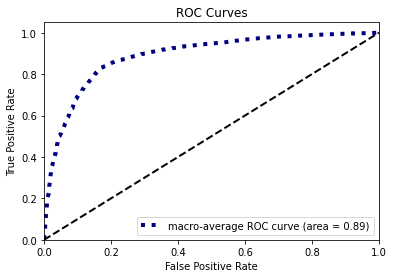

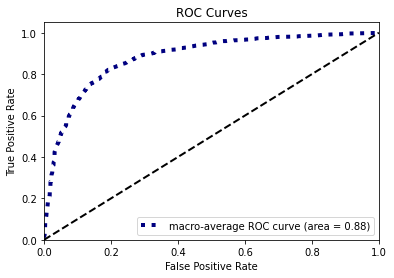

In [80]:
plot_roc_curve(y_true=yt['churn'],y_probas=lr.predict_proba(Zt[varz]),curves='macro')
plot_roc_curve(y_true=yv['churn'],y_probas=lr.predict_proba(Zv[varz]),curves='macro')

In [81]:
Xt,Xv,yt,yv= train_test_split(X[varc+um],X[um+['churn']],train_size=0.7)

In [82]:
lr.fit(Xt[varc],yt['churn'])

LogisticRegression(max_iter=31706)

/home/jose/entornos/churn/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
/home/jose/entornos/churn/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

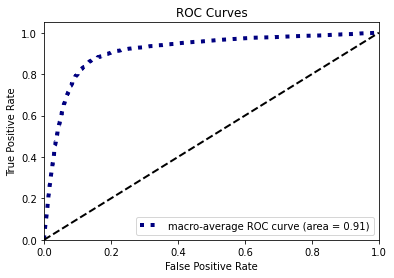

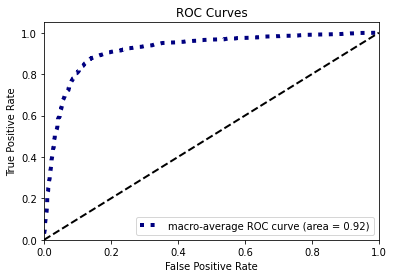

In [83]:
plot_roc_curve(y_true=yt['churn'],y_probas=lr.predict_proba(Xt[varc]),curves='macro')
plot_roc_curve(y_true=yv['churn'],y_probas=lr.predict_proba(Xv[varc]),curves='macro')

## Resultados

In [84]:
Xt['proba'] = lr.predict_proba(Xt[varc])[:,1]
Xv['proba'] = lr.predict_proba(Xv[varc])[:,1]

In [85]:
Xt['churn'] = yt['churn']
Xv['churn'] = yv['churn']

In [86]:
aux = pd.concat([Xt[['proba','churn']+um].assign(sample='train'),
Xv[['proba','churn']+um].assign(sample='valid')],ignore_index=True)

In [87]:
aux['r_proba'] = pd.cut(aux['proba'],bins=np.arange(0,1.1,0.1),include_lowest=True).astype(str)

In [88]:
aux[['r_proba','sample','churn','taxi_id']].groupby(['r_proba','sample','churn']).count().to_clipboard()

## Estimación de CLTV (Customer LifeTime Value)

In [89]:
aux = df[['taxi_id','trip_start_timestamp']].copy()
aux['mes'] = df['trip_start_timestamp'].map(lambda x:x.strftime('%m'))

In [90]:
aux.drop('trip_start_timestamp',axis=1,inplace=True)

In [91]:
aux = aux.drop_duplicates().reset_index(drop=True)

In [92]:
aux = aux.groupby('taxi_id').count()

In [93]:
aux = aux.loc[aux['mes']==12]

In [94]:
aux.reset_index(inplace=True)

In [95]:
aux = aux.merge(df[['trip_total','taxi_id']],on='taxi_id',how='inner')

In [96]:
aux = aux.drop('mes',axis=1).groupby('taxi_id').sum().reset_index()

array([[<AxesSubplot:title={'center':'trip_total'}>]], dtype=object)

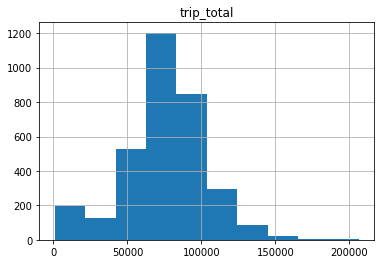

In [97]:
aux.hist()

In [98]:
aux.describe()*0.3

,trip_total
count,994.200000
mean,22460.325912
std,8356.672510
min,238.587000
25%,18618.725250
50%,22860.508500
75%,27168.537000
max,61956.807000


In [99]:
18,600Pesimista
22,800Más probale
27,100Optimista

SyntaxError: invalid syntax (<ipython-input-99-1f73573a715e>, line 1)

In [ ]:
5-50

In [ ]:
(df.trip_total.sum())/10**6

In [ ]:
df.shape

In [101]:
X.shape

(15853, 354)

In [102]:
X.head()

,x_min_extras_payment_type_Cash_2,x_min_extras_payment_type_Credit Card_2,x_min_fare_payment_type_Cash_2,x_min_fare_payment_type_Credit Card_2,x_min_tips_payment_type_Credit Card_2,x_min_trip_miles_payment_type_Cash_2,x_min_trip_miles_payment_type_Credit Card_2,x_min_trip_seconds_payment_type_Cash_2,x_min_trip_seconds_payment_type_Credit Card_2,x_min_trip_total_payment_type_Cash_2,x_min_trip_total_payment_type_Credit Card_2,x_max_extras_payment_type_Cash_2,x_max_extras_payment_type_Credit Card_2,x_max_fare_payment_type_Cash_2,x_max_fare_payment_type_Credit Card_2,x_max_tips_payment_type_Cash_2,x_max_tips_payment_type_Credit Card_2,x_max_tolls_payment_type_Cash_2,x_max_tolls_payment_type_Credit Card_2,x_max_trip_miles_payment_type_Cash_2,x_max_trip_miles_payment_type_Credit Card_2,x_max_trip_seconds_payment_type_Cash_2,x_max_trip_seconds_payment_type_Credit Card_2,x_max_trip_total_payment_type_Cash_2,x_max_trip_total_payment_type_Credit Card_2,x_mean_extras_payment_type_Cash_2,x_mean_extras_payment_type_Credit Card_2,x_mean_fare_payment_type_Cash_2,x_mean_fare_payment_type_Credit Card_2,x_mean_tips_payment_type_Cash_2,x_mean_tips_payment_type_Credit Card_2,x_mean_tolls_payment_type_Cash_2,x_mean_tolls_payment_type_Credit Card_2,x_mean_trip_miles_payment_type_Cash_2,x_mean_trip_miles_payment_type_Credit Card_2,x_mean_trip_seconds_payment_type_Cash_2,x_mean_trip_seconds_payment_type_Credit Card_2,x_mean_trip_total_payment_type_Cash_2,x_mean_trip_total_payment_type_Credit Card_2,x_median_extras_payment_type_Cash_2,x_median_extras_payment_type_Credit Card_2,x_median_fare_payment_type_Cash_2,x_median_fare_payment_type_Credit Card_2,x_median_tips_payment_type_Credit Card_2,x_median_trip_miles_payment_type_Cash_2,x_median_trip_miles_payment_type_Credit Card_2,x_median_trip_seconds_payment_type_Cash_2,x_median_trip_seconds_payment_type_Credit Card_2,x_median_trip_total_payment_type_Cash_2,x_median_trip_total_payment_type_Credit Card_2,x_std_extras_payment_type_Cash_2,x_std_extras_payment_type_Credit Card_2,x_std_fare_payment_type_Cash_2,x_std_fare_payment_type_Credit Card_2,x_std_tips_payment_type_Cash_2,x_std_tips_payment_type_Credit Card_2,x_std_tolls_payment_type_Cash_2,x_std_tolls_payment_type_Credit Card_2,x_std_trip_miles_payment_type_Cash_2,x_std_trip_miles_payment_type_Credit Card_2,x_std_trip_seconds_payment_type_Cash_2,x_std_trip_seconds_payment_type_Credit Card_2,x_std_trip_total_payment_type_Cash_2,x_std_trip_total_payment_type_Credit Card_2,x_count_extras_payment_type_Cash_2,x_count_extras_payment_type_Credit Card_2,x_count_fare_payment_type_Cash_2,x_count_fare_payment_type_Credit Card_2,x_count_tips_payment_type_Cash_2,x_count_tips_payment_type_Credit Card_2,x_count_tolls_payment_type_Cash_2,x_count_tolls_payment_type_Credit Card_2,x_count_trip_miles_payment_type_Cash_2,x_count_trip_miles_payment_type_Credit Card_2,x_count_trip_seconds_payment_type_Cash_2,x_count_trip_seconds_payment_type_Credit Card_2,x_count_trip_total_payment_type_Cash_2,x_count_trip_total_payment_type_Credit Card_2,x_min_trip_seconds_2_tot,x_max_trip_seconds_2_tot,x_mean_trip_seconds_2_tot,x_median_trip_seconds_2_tot,x_std_trip_seconds_2_tot,x_min_trip_miles_2_tot,x_max_trip_miles_2_tot,x_mean_trip_miles_2_tot,x_median_trip_miles_2_tot,x_std_trip_miles_2_tot,x_min_fare_2_tot,x_max_fare_2_tot,x_mean_fare_2_tot,x_median_fare_2_tot,x_std_fare_2_tot,x_min_tips_2_tot,x_max_tips_2_tot,x_mean_tips_2_tot,x_median_tips_2_tot,x_std_tips_2_tot,x_max_tolls_2_tot,x_mean_tolls_2_tot,x_std_tolls_2_tot,x_min_extras_2_tot,x_max_extras_2_tot,x_mean_extras_2_tot,x_median_extras_2_tot,x_std_extras_2_tot,x_min_trip_total_2_tot,x_max_trip_total_2_tot,x_mean_trip_total_2_tot,x_median_trip_total_2_tot,x_std_trip_total_2_tot,x_min_extras_payment_type_Cash_4,x_min_extras_payment_type_Credit Card_4,x_min_fare_payment_type_Cash_4,x_min_fare_payment_type_Credit Card_4,x_min_tips_payment_type_Credit Card_4,x_min_trip_miles_payment_type_Cash_4,x_min_trip_miles_payment_type_Credit C

In [104]:
X.to_pickle('tad_churn.pkl')